# Application of approximate TBCs to the Schwarz method

$ \newcommand{\laplinv}{\mathcal{L}^{-1}}$


## Description of the problem

In this notebook, we will apply approximate Transparent Boundary Conditions to the Schwarz method, for the resolution of the linearized KdV equation in a decomposed domain.

The problem to be solved in the full domain $\Omega = [-L,L]$ is

\begin{equation}
    \begin{cases}
        u_t + u_{xxx} = 0 , \ \ x \in \Omega, \ \ t \leq 0\\
        u(0,x) = u_0(x) , \ \ x \in \Omega \\
        \text{+ Boundary conditions}
    \end{cases}
\end{equation}

As described previously, following the paper of Besse et al (2015), the TBCs for this problem have the form

\begin{equation}
\label{eq:TBC}
    \begin{cases}
        u(t,-L) -\laplinv \left( \frac{\lambda(s)^2}{s} \right) * u_x(t,-L) -  \laplinv \left( \frac{\lambda(s)}{s} \right) * u_{xx}(t,-L) = 0 \\
        u(t,L) - \laplinv \left( \frac{1}{\lambda(s)^2} \right) * u_{xx}(t,L) = 0 \\
        u_x(t,L) - \laplinv \left( \frac{1}{\lambda(s)} \right) * u_{xx}(t,L) = 0 
    \end{cases}
\end{equation}

where $\laplinv$ denotes the inverse Laplace transform (with complex frequencies $s$ such that $Re(s) > 0$) and $\lambda(s) = -\sqrt[3]{s}$ is one of the roots of the cubic characteristic polynomial obtained when solving the equation in the Laplace domain.

The approach proposed here consisted in approximating $\frac{\lambda^2}{s}$ by a constant polynomial $P_0(s) = c$, leading to

\begin{equation}
\label{eq:TBC3}
    \begin{cases}
        \Theta_1^{c_L}(u,-L) = u(t,-L) - c_L u_x(t,-L)  + c_L^2   u_{xx}(t,-L) = 0 \\
        \Theta_2^{c_R}(u,L) = u(t,L) - c_R^2    \hat{u}_{xx}(t,L) = 0 \\
        \Theta_3^{c_R}(u,L) = u_x(t,L) + c_R u_{xx}(t,L)= 0 
    \end{cases}
\end{equation}

For a given initial solution, the coefficients $c_L$ (on the left boundary) and $c_R$ (on the right boundary) were optimized, in a sense of minimizing the error between the computed and the exacted solution. The optimal coefficients will be noted as $c_L^* and c_R^*$

Now we will implement the optimal approximate TBCs to the resolution of the linearized KdV equation in a decomposed domain, $\Omega = \Omega_1 \bigcup \Omega_2, \ \ \Omega_1 = [-L,0], \ \ \Omega_2 = [0,L]$ :

\begin{equation}
    \begin{cases}
        (u_i)_t + (u_i)_{xxx} = 0 , \ \ x \in \Omega_i, \ \ t \leq 0\\
        u_i(0,x) = u_0(x) , \ \ x \in \Omega_i \\
        \text{+ Boundary conditions}
    \end{cases}
\end{equation}

for $i=1,2$

## The additive Schwarz method

As described in the paper of Japhet and Nataf (2003), the additive Schwarz method is an iterative algorithm for solving a problem in a decomposed domain. In each time step $t_n$, the solution $u_i^{n,\infty}$ is computed as the convergence of the solution obtained in each iteration, $u_i^{n,k}, \ \ k\geq 0$. For computing this solution $u_i^{n,k}$, the problem is solved with TBCs constructed using the solution $u_j^{n,k-1}, \ \ j \neq i$ in the other partitions of the domain, in the previous iteration. In each interface between the domains $\Omega_i$ and $\Omega_j$, the boundary condition for the problem in $\Omega_i$ is

$$\mathcal{B}(u_i^{n,k+1}) = \mathcal{B}(u_j^{n,k})$$

where $\mathcal{B}$ denotes the operator of the TBC.

We will use the optimal approximate TBCs for solving the linearized KdV equation with the Schwarz method. Therefore, the problem to be solved can be written as, in each time step

\begin{equation}
    \begin{cases}
        (u_1^{n,k+1})_t + (u_1^{n,k+1})_{xxx} = 0 , \ \ x \in \Omega_1, \ \ t \leq 0\\
        u_1^{n,0} = u_1^{n-1,\infty} , \ \ x \in \Omega_1 \\
        \Theta_1^{c_L^*}(u_1^{n,k+1},-L) = 0 \\
        \Theta_2^{c_R^*}(u_1^{n,k+1},0) = \Omega_2^{c_R^*}(u_2^{n,k}) \\
        \Theta_3^{c_R^*}(u_1^{n,k+1},0) = \Omega_3^{c_R^*}(u_2^{n,k})
     \end{cases}
\end{equation}

\begin{equation}
    \begin{cases}
        (u_2^{n,k+1})_t + (u_2^{n,k+1})_{xxx} = 0 , \ \ x \in \Omega_2, \ \ t \leq 0\\
        u_2^{n,0} = u_2^{n-1,\infty} , \ \ x \in \Omega_2 \\
        \Theta_1^{c_L^*}(u_2^{n,k+1},0) = \Omega_1^{c_L^*}(u_1^{n,k}) \\
        \Theta_2^{c_R^*}(u_2^{n,k+1},L) = 0 \\
        \Theta_3^{c_R^*}(u_2^{n,k+1},L) = 0
     \end{cases}
\end{equation}


In [45]:
import numpy as np
import kdv
import besseTBC
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [46]:
## Returns TBC computed in \Omega_j for the resolution in \Omega_i

def computeExteriorTBC(u,dx,cL,cR,cond,order=2) :
    
    if cond == 1:
        if order == 2:
            return u[-1] - cL/dx*(3./2.*u[-1] - 2.*u[-2] + 1./2.*u[-3]) + cL*cL/(dx*dx)*(u[-1] - 2.*u[-2] + u[-3])
    elif cond == 2:
        if order == 2:
            return u[0] - cR*cR/(dx*dx)*(u[0] - 2.*u[1] + u[2])
    elif cond == 3:
        if order == 2:
            return 1./dx*(u[1]-u[0]) + cR/(dx*dx)*(u[0] - 2.*u[1] + u[2])

In [47]:
def verifyConvergence(u1,u1prev,u2,u2prev,eps):
    if (np.linalg.norm(u1-u1prev) < eps) and (np.linalg.norm(u2-u2prev) < eps):
        return True
    else:
        return False

In [51]:
## Additive Schwarz method (for solving one time step)

def ASM(x1,x2,u1,u2,t,dx,dt,order,cL,cR,maxiter,eps):
    
    converg = False
    niter = 0
    u1prev = np.copy(u1)
    u2prev = np.copy(u2)
    while converg == False and niter <= maxiter :
        niter = niter + 1
        
        BC1 = np.zeros(3)
        BC1[1] = computeExteriorTBC(u2,dx,cL,cR,2) 
        BC1[2] = computeExteriorTBC(u2,dx,cL,cR,3)

        BC2 = np.zeros(3)
        BC2[1] = computeExteriorTBC(u1,dx,cL,cR,1)

        u1m = np.copy(u1)
        u2m = np.copy(u2)

        coef = np.zeros((1,2))
        coef[0,0] = cL
        coef[0,1] = cR

        u1 = besseTBC.IFDBesse(u1,None,None,t,dt,dx,1.,0,coef,BC1)
        u2 = besseTBC.IFDBesse(u2,None,None,t,dt,dx,1.,0,coef,BC2)

        converg = verifyConvergence(u1,u1m,u2,u2m,eps)
        
    return u1,u2,niter, np.linalg.norm(u1-u1prev), np.linalg.norm(u2-u2prev)

In [52]:
def runSimulation(x1,x2,u1,u2,t0,tmax,dx,dt,cL,cR,maxiter = 10,eps = 1e-6) :

    print("")
    print("*** Computing solution ...")
    
    t = t0
    uall1 = np.copy(u1)
    uall2 = np.copy(u2)
    tall = np.ones(1)*t0
    niterall = np.zeros(1)
    err1all = np.zeros(1)
    err2all = np.zeros(1)
    
    while t < tmax :
        
        t = t+dt
        print(t)
        u1,u2,niter,err1,err2 = ASM(x1,x2,u1,u2,t,dx,dt,0,cL,cR,maxiter,eps)

        uall1 = np.column_stack((uall1,u1))
        uall2 = np.column_stack((uall2,u2))
        tall = np.hstack((tall,t*np.ones(1)))
        niterall = np.hstack((niterall,niter*np.ones(1)))
        err1all = np.hstack((err1all,err1*np.ones(1)))
        err2all = np.hstack((err2all,err1*np.ones(1)))
        if niter%100 == 0 and verbose:
            print(niter,t)
            
    print("*** End of computation ***")        
    return uall1,uall2,tall,niterall,err1all,err2all

In [61]:
computeExactSolution = False

L = 6.
xmin = -L
xmax = L
N = 499.
U2 = 1.
t0 = 0.
tmax = .2
dt = 5*4/2560.

dx = (xmax-xmin)/N
x = kdv.discretizeSpace(xmin,xmax,dx)
x = np.linspace(xmin,xmax,N)
xx = np.linspace(xmin,xmax,N+1)
cLs = np.arange(1.0,1.22,0.01)
cRs = np.array([1.])

x1 = x[0:x.size/2+1]
x2 = x[x.size/2:]

u = besseTBC.initGauss(x)
u1 = besseTBC.initGauss(x1)
u2 = besseTBC.initGauss(x2)

tallaux = np.arange(t0,tmax+dt,dt)

uallexact = np.zeros((u.size,tallaux.size))
uallexact[:,0] = np.copy(u)

if computeExactSolution :
    print("*** Computing initial solution")
    for i in range(1,tallaux.size) :
        if i%10 == 0:
            print(r"t = %.6f"%tallaux[i])
        uallexact[:,i] = besseTBC.exactSolution(x,tallaux[i],besseTBC.initGauss)

    #Save initial solution
    fn = "initGauss"
    with open(fn,'w') as f:
        pickle.dump(uallexact,f)
    uallexact2 = np.copy(uallexact)
else :
    #Load initial solution
    fn = "initGauss"
    with open(fn,'r') as f:
        uallexact = pickle.load(f)
#print(np.linalg.norm(uallexact-uallexact2))


cL = 1.16
cR = 1.
uall1,uall2,tall,niterall,err1all,err2all = runSimulation(x1,x2,u1,u2,t0,tmax,dx,dt,cL,cR,maxiter = 100,eps = 1e-6)



*** Computing solution ...
0.0078125
0.015625
0.0234375
0.03125
0.0390625
0.046875
0.0546875
0.0625
0.0703125
0.078125
0.0859375
0.09375
0.1015625
0.109375
0.1171875
0.125
0.1328125
0.140625
0.1484375
0.15625
0.1640625
0.171875
0.1796875
0.1875
0.1953125
0.203125
*** End of computation ***


(array([   0.,  101.,  101.,  101.,  101.,  101.,  101.,  101.,  101.,
        101.,  101.,  101.,  101.,  101.,  101.,  101.,  101.,  101.,
        101.,  101.,  101.,  101.,  101.,  101.,  101.,  101.,  101.]), array([ 0.        ,  5.36105239,  4.98455379,  2.76095468,  3.78301724,
        3.07623975,  2.62977278,  2.73440081,  1.47201924,  2.00020071,
        1.3178267 ,  1.54267397,  1.49035956,  1.29351127,  1.17913376,
        0.99801949,  0.63945129,  0.76296629,  0.44618995,  0.62197649,
        0.52635346,  0.4427659 ,  0.45737916,  0.25806231,  0.31618106,
        0.23492922,  0.24871144]), array([ 0.        ,  5.36105239,  4.98455379,  2.76095468,  3.78301724,
        3.07623975,  2.62977278,  2.73440081,  1.47201924,  2.00020071,
        1.3178267 ,  1.54267397,  1.49035956,  1.29351127,  1.17913376,
        0.99801949,  0.63945129,  0.76296629,  0.44618995,  0.62197649,
        0.52635346,  0.4427659 ,  0.45737916,  0.25806231,  0.31618106,
        0.23492922,  0.24871144]

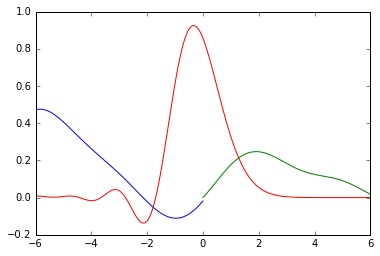

In [63]:
i=10
plt.plot(x1,uall1[:,i],x2,uall2[:,i],xx,uallexact[:,i])
print(niterall,err1all,err2all)